<a href="https://colab.research.google.com/github/TheSpiralArchitect/spiral-resonance-validation/blob/main/phase11_dna_rna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 83.9 MB/s eta 0:00:00
DNA Segment: Human Chr1:1,000,000–1,005,000
Length: 5001
SRF (ω=0.4, n=3): -0.00075
LZC (original): 842.0000
LZC (null mean ± std): 852.7400 ± 2.1846
Entropy (original): 1.5017
Entropy (null mean ± std): 1.5017 ± 0.0000
Top Motifs: [('AAAAA', 194), ('BAAAA', 94), ('AAAAB', 94), ('AABAA', 83), ('ABAAA', 76)]



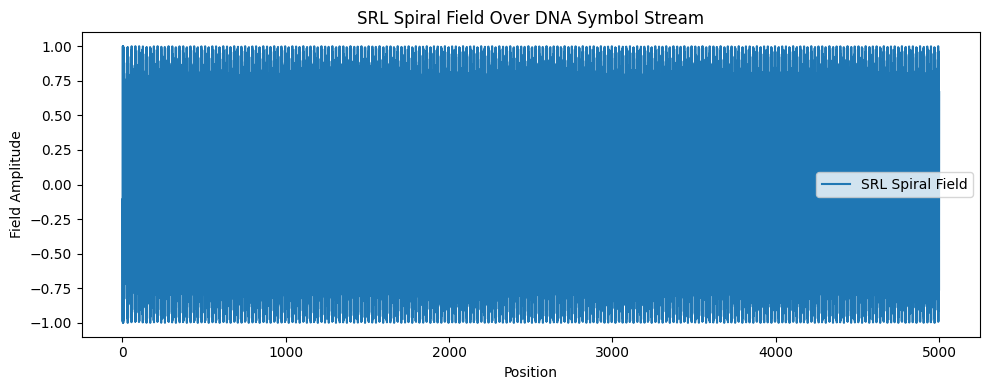

In [2]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Install Biopython ---
!pip install biopython

# --- Import Modules ---
import numpy as np
import random
from Bio import Entrez, SeqIO
from collections import Counter
import matplotlib.pyplot as plt
import math
import os

# --- Setup Drive Save Directory ---
save_dir = '/content/drive/MyDrive/SRL'
os.makedirs(save_dir, exist_ok=True)

# --- Fetch DNA Segment (Human Chromosome 1) ---
Entrez.email = "ekaj111213@hotmail.co.uk"

def fetch_dna(chromosome='NC_000001.11', start=1000000, end=1005000):
    handle = Entrez.efetch(
        db="nucleotide", id=chromosome, rettype="fasta", strand=1,
        seq_start=start, seq_stop=end
    )
    record = SeqIO.read(handle, "fasta")
    return str(record.seq).upper()

dna_seq = fetch_dna()

# --- Save DNA Sequence to File ---
with open(f"{save_dir}/dna_segment.fasta", "w") as f:
    f.write(">Human_Chr1_1000000_1005000\n")
    f.write(dna_seq)

# --- DNA → Symbolic Motif Conversion ---
def dna_to_symbols(seq):
    base_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    numeric = np.array([base_map.get(b, -1) for b in seq if b in base_map])
    bins = np.percentile(numeric, [33, 66])
    symbols = []
    for val in numeric:
        if val <= bins[0]: symbols.append('A')
        elif val <= bins[1]: symbols.append('B')
        else: symbols.append('H')
    return symbols

symbol_stream = dna_to_symbols(dna_seq)

# --- Extract Motifs and LZC ---
def extract_5mers(symbols):
    return [''.join(symbols[i:i+5]) for i in range(len(symbols)-4)]

def lz_complexity(s):
    i, k, l = 0, 1, 1
    sub_strings = set()
    while True:
        if s[i:i+l] in sub_strings:
            l += 1
        else:
            sub_strings.add(s[i:i+l])
            i += l
            l = 1
        if i + l > len(s):
            break
    return len(sub_strings)

def symbol_entropy(s):
    counts = Counter(s)
    probs = np.array([c/len(s) for c in counts.values()])
    return -np.sum(probs * np.log2(probs))

motifs = extract_5mers(symbol_stream)
motif_counts = Counter(motifs)
lz_original = lz_complexity(''.join(symbol_stream))
entropy_original = symbol_entropy(symbol_stream)

# --- Null Model Comparison (Shuffling) ---
lz_null, entropy_null = [], []
for _ in range(100):
    shuffled = symbol_stream.copy()
    random.shuffle(shuffled)
    lz_null.append(lz_complexity(''.join(shuffled)))
    entropy_null.append(symbol_entropy(shuffled))

# --- Spiral Resonance Factor (SRF) ---
def compute_srf(symbols, omega=0.4, n=3, epsilon=1e-5):
    thetas = np.arange(len(symbols))
    field = np.cos(omega * np.log(thetas + epsilon) + n * thetas)
    alignment = []
    for i, sym in enumerate(symbols):
        if sym == 'A': alignment.append(field[i])
        elif sym == 'B': alignment.append(0.5 * field[i])
        elif sym == 'H': alignment.append(-field[i])
    return np.mean(alignment)

srf_dna = compute_srf(symbol_stream)

# --- Print and Save Results ---
results_text = f"""DNA Segment: Human Chr1:1,000,000–1,005,000
Length: {len(dna_seq)}
SRF (ω=0.4, n=3): {srf_dna:.5f}
LZC (original): {lz_original:.4f}
LZC (null mean ± std): {np.mean(lz_null):.4f} ± {np.std(lz_null):.4f}
Entropy (original): {entropy_original:.4f}
Entropy (null mean ± std): {np.mean(entropy_null):.4f} ± {np.std(entropy_null):.4f}
Top Motifs: {motif_counts.most_common(5)}
"""

print(results_text)
with open(f"{save_dir}/dna_srl_results.txt", "w") as f:
    f.write(results_text)

# --- Save Spiral Field Plot ---
plt.figure(figsize=(10,4))
spiral_field = np.cos(0.4 * np.log(np.arange(len(symbol_stream)) + 1e-5) + 3 * np.arange(len(symbol_stream)))
plt.plot(spiral_field, label='SRL Spiral Field')
plt.title("SRL Spiral Field Over DNA Symbol Stream")
plt.xlabel("Position")
plt.ylabel("Field Amplitude")
plt.legend()
plt.tight_layout()
plt.savefig(f"{save_dir}/spiral_field_plot.png")
plt.show()

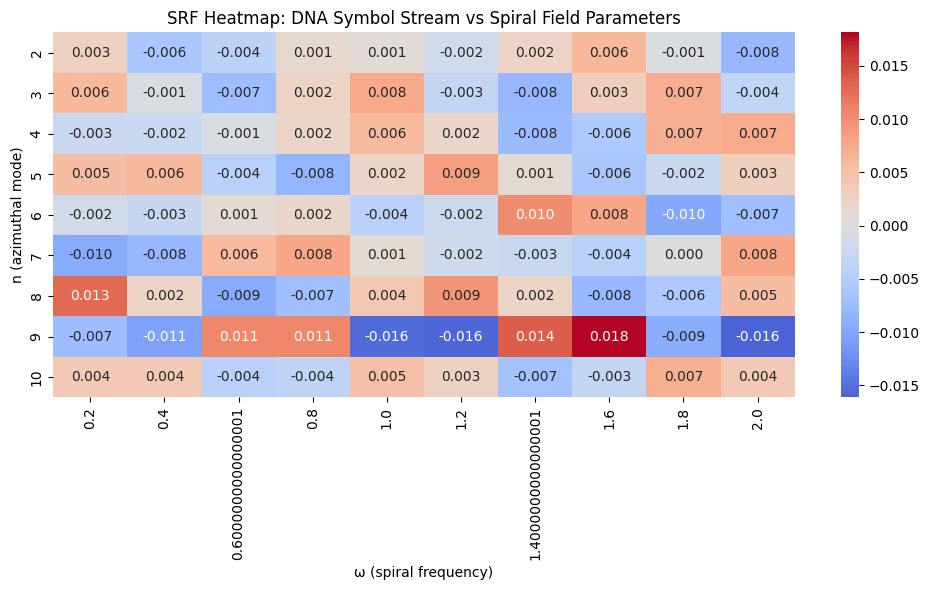

In [3]:
import pandas as pd
import seaborn as sns

# --- Sweep over ω and n ---
omega_vals = np.linspace(0.2, 2.0, 10)
n_vals = list(range(2, 11))

results = []

for omega in omega_vals:
    for n in n_vals:
        srf = compute_srf(symbol_stream, omega=omega, n=n)
        results.append({'omega': omega, 'n': n, 'SRF': srf})

# --- Create DataFrame ---
df = pd.DataFrame(results)

# --- Save to Drive ---
df.to_csv(f"{save_dir}/dna_srf_parameter_sweep.csv", index=False)

# --- Heatmap of SRF vs (omega, n) ---
pivot = df.pivot(index='n', columns='omega', values='SRF')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap='coolwarm', center=0, fmt=".3f")
plt.title("SRF Heatmap: DNA Symbol Stream vs Spiral Field Parameters")
plt.xlabel("ω (spiral frequency)")
plt.ylabel("n (azimuthal mode)")
plt.tight_layout()
plt.savefig(f"{save_dir}/dna_srf_heatmap.png")
plt.show()

In [4]:
# --- BRCA1 Coding Segment ---
brca_seq = fetch_dna(chromosome='NC_000017.11', start=43044294, end=43049294)
brca_symbols = dna_to_symbols(brca_seq)

# --- Non-Coding Region ---
noncode_seq = fetch_dna(chromosome='NC_000017.11', start=43120000, end=43125000)
noncode_symbols = dna_to_symbols(noncode_seq)

# --- Define Metrics ---
def analyze_symbolic_stream(symbols, label):
    motifs = extract_5mers(symbols)
    motif_counts = Counter(motifs)
    lz = lz_complexity(''.join(symbols))
    entropy = symbol_entropy(symbols)
    srf = compute_srf(symbols)
    print(f"{label} | LZC: {lz}, Entropy: {entropy:.4f}, SRF: {srf:.5f}")
    return {
        'label': label,
        'lz': lz,
        'entropy': entropy,
        'srf': srf,
        'top_motifs': motif_counts.most_common(5)
    }

# --- Run Analyses ---
brca_result = analyze_symbolic_stream(brca_symbols, 'BRCA1 (Coding)')
noncode_result = analyze_symbolic_stream(noncode_symbols, 'Non-Coding')

# --- Save to Drive ---
with open(f"{save_dir}/coding_vs_noncoding_srl.txt", "w") as f:
    for r in [brca_result, noncode_result]:
        f.write(f"{r['label']}\n")
        f.write(f"SRF: {r['srf']:.5f}, LZC: {r['lz']}, Entropy: {r['entropy']:.4f}\n")
        f.write(f"Top Motifs: {r['top_motifs']}\n\n")

BRCA1 (Coding) | LZC: 833, Entropy: 1.4970, SRF: -0.00428
Non-Coding | LZC: 831, Entropy: 1.4759, SRF: -0.01000


In [5]:
# --- Mouse BRCA1 region: NC_000072.7 (Chromosome 11, mouse BRCA1) ---
# Approximate exon match region: 101,000,000–101,005,000
mouse_seq = fetch_dna(chromosome='NC_000072.7', start=101000000, end=101005000)
mouse_symbols = dna_to_symbols(mouse_seq)

# --- Analyze Mouse ---
mouse_result = analyze_symbolic_stream(mouse_symbols, 'Mouse BRCA1 (Coding)')

# --- Save Result Comparison to Drive ---
with open(f"{save_dir}/human_vs_mouse_brca1_srl.txt", "w") as f:
    f.write(f"Human BRCA1 | SRF: {brca_result['srf']:.5f}, LZC: {brca_result['lz']}, Entropy: {brca_result['entropy']:.4f}\n")
    f.write(f"Mouse BRCA1 | SRF: {mouse_result['srf']:.5f}, LZC: {mouse_result['lz']}, Entropy: {mouse_result['entropy']:.4f}\n")
    f.write(f"\nTop Human Motifs: {brca_result['top_motifs']}\n")
    f.write(f"Top Mouse Motifs: {mouse_result['top_motifs']}\n")

Mouse BRCA1 (Coding) | LZC: 839, Entropy: 1.5406, SRF: 0.00220


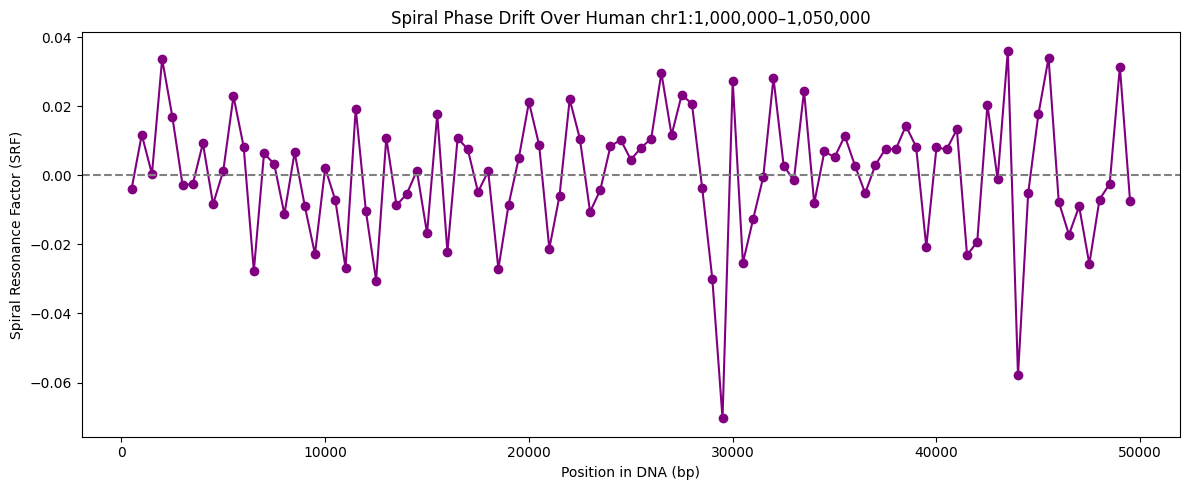

In [6]:
# --- Fetch 50kb Segment (Human chr1: 1,000,000–1,050,000) ---
long_seq = fetch_dna(chromosome='NC_000001.11', start=1000000, end=1050000)
long_symbols = dna_to_symbols(long_seq)

# --- Sliding SRF Computation ---
window_size = 1000
step_size = 500
positions = []
srfs = []

for i in range(0, len(long_symbols) - window_size + 1, step_size):
    window = long_symbols[i:i+window_size]
    srf = compute_srf(window)
    positions.append(i + 500)  # midpoint of window
    srfs.append(srf)

# --- Plot SRF Drift Over DNA Region ---
plt.figure(figsize=(12, 5))
plt.plot(positions, srfs, marker='o', linestyle='-', color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Spiral Phase Drift Over Human chr1:1,000,000–1,050,000")
plt.xlabel("Position in DNA (bp)")
plt.ylabel("Spiral Resonance Factor (SRF)")
plt.tight_layout()
plt.savefig(f"{save_dir}/spiral_phase_drift_chr1.png")
plt.show()

# --- Save Drift Data to Drive ---
import pandas as pd
drift_df = pd.DataFrame({'position': positions, 'srf': srfs})
drift_df.to_csv(f"{save_dir}/spiral_phase_drift_chr1.csv", index=False)

In [7]:
# --- Parameters for scan ---
window_size = 1000
step_size = 500
motif_srf_data = []

# --- Scan windows and store motifs with SRF ---
for i in range(0, len(long_symbols) - window_size + 1, step_size):
    window = long_symbols[i:i+window_size]
    motifs = extract_5mers(window)
    srf = compute_srf(window)
    for m in motifs:
        motif_srf_data.append({'motif': m, 'srf': srf})

# --- Aggregate SRF values by motif ---
motif_df = pd.DataFrame(motif_srf_data)
motif_stats = motif_df.groupby('motif')['srf'].agg(['count', 'mean', 'std']).reset_index()

# --- Filter motifs with sufficient counts ---
filtered = motif_stats[motif_stats['count'] >= 10].sort_values('mean', ascending=False)

# --- Save to Drive ---
filtered.to_csv(f"{save_dir}/spiral_motif_srf_map.csv", index=False)

# --- Show top/bottom motifs ---
print("Top Spiral-Aligned Motifs:")
print(filtered.head(10))

print("\nTop Spiral-Breaking Motifs:")
print(filtered.tail(10))

Top Spiral-Aligned Motifs:
     motif  count      mean       std
206  HBBHH     50  0.005865  0.013884
175  HABBB    144  0.005269  0.015461
219  HHABA     92  0.004319  0.016579
154  BHHAB     54  0.004198  0.015364
198  HBBAA    569  0.003763  0.016753
149  BHBBH    153  0.003722  0.016595
139  BHABB    102  0.003679  0.016776
51   ABHHA     87  0.003530  0.015310
133  BBHHB     56  0.003503  0.017859
98   BABHH    101  0.003414  0.014432

Top Spiral-Breaking Motifs:
     motif  count      mean       std
125  BBBHH    123 -0.002622  0.017457
209  HBHAH    184 -0.002794  0.019805
50   ABHBH    266 -0.002954  0.024179
75   AHHBA    153 -0.003039  0.016254
146  BHBAH    308 -0.003050  0.022590
167  HAABH    131 -0.003150  0.020253
156  BHHBA     72 -0.003371  0.019363
210  HBHBA    487 -0.003773  0.024470
151  BHBHB    743 -0.006479  0.027737
212  HBHBH    604 -0.007139  0.028194


In [8]:
# --- tRNA-Leu (Human mitochondrial, NC_012920.1, 3230–3304) ---
trna_seq = fetch_dna(chromosome='NC_012920.1', start=3230, end=3304)
trna_symbols = dna_to_symbols(trna_seq)
trna_result = analyze_symbolic_stream(trna_symbols, 'Human tRNA-Leu')

# --- 16S rRNA Segment (E. coli, NR_024570.1, 1–1500) ---
rrna_seq = fetch_dna(chromosome='NR_024570.1', start=1, end=1500)
rrna_symbols = dna_to_symbols(rrna_seq)
rrna_result = analyze_symbolic_stream(rrna_symbols, 'E. coli 16S rRNA (partial)')

# --- Save to Drive ---
with open(f"{save_dir}/spiral_roots_trna_rrna.txt", "w") as f:
    for r in [trna_result, rrna_result]:
        f.write(f"{r['label']}\n")
        f.write(f"SRF: {r['srf']:.5f}, LZC: {r['lz']}, Entropy: {r['entropy']:.4f}\n")
        f.write(f"Top Motifs: {r['top_motifs']}\n\n")

Human tRNA-Leu | LZC: 28, Entropy: 1.5726, SRF: 0.00434
E. coli 16S rRNA (partial) | LZC: 298, Entropy: 1.4983, SRF: -0.01310


In [9]:
# --- Build sweep function for symbolic motif mapping ---
def motif_srf_map(symbol_stream, label):
    motif_srf_data = []
    window_size = 20  # smaller window for tRNA/rRNA scale
    step_size = 5
    for i in range(0, len(symbol_stream) - window_size + 1, step_size):
        window = symbol_stream[i:i+window_size]
        motifs = extract_5mers(window)
        srf = compute_srf(window)
        for m in motifs:
            motif_srf_data.append({'motif': m, 'srf': srf})

    df = pd.DataFrame(motif_srf_data)
    motif_stats = df.groupby('motif')['srf'].agg(['count', 'mean', 'std']).reset_index()
    motif_stats = motif_stats[motif_stats['count'] >= 3].sort_values('mean', ascending=False)
    df_path = f"{save_dir}/spiral_motifs_{label.replace(' ', '_')}.csv"
    motif_stats.to_csv(df_path, index=False)

    print(f"\nTop Spiral-Aligned Motifs in {label}:")
    print(motif_stats.head(5))
    print(f"\nTop Spiral-Breaking Motifs in {label}:")
    print(motif_stats.tail(5))

# --- Run on tRNA and rRNA ---
motif_srf_map(trna_symbols, 'tRNA_Leu')
motif_srf_map(rrna_symbols, 'rRNA_16S')


Top Spiral-Aligned Motifs in tRNA_Leu:
    motif  count      mean       std
37  BHHAA      5  0.052539  0.059681
54  HHBAA      4  0.043263  0.083722
22  BAHAA      3  0.032937  0.056141
14  AHAAA      3  0.032937  0.056141
16  AHHBB      3  0.027938  0.095420

Top Spiral-Breaking Motifs in tRNA_Leu:
    motif  count      mean       std
30  BBBHA      3 -0.024285  0.086658
31  BBHAA      3 -0.024285  0.086658
43  HAAHB      4 -0.026157  0.070855
9   ABBBB      3 -0.032289  0.073962
19  BABBB      3 -0.032289  0.073962

Top Spiral-Aligned Motifs in rRNA_16S:
     motif  count      mean       std
176  HAHBB      6  0.068240  0.274962
128  BBHBH      3  0.055492  0.261064
148  BHBHH      3  0.038296  0.085537
62   AHBAB     17  0.036397  0.161009
216  HHHAA      9  0.034489  0.084775

Top Spiral-Breaking Motifs in rRNA_16S:
     motif  count      mean       std
173  HAHAA      3 -0.049489  0.055910
100  BAHBB     13 -0.049905  0.153752
75   AHHBH      4 -0.055534  0.083508
98   BAHAH    